# Twitter sentiment analysis with TFIDF Vectorizer

In [1]:

# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.lang.en.examples import sentences 
from spacy.cli import download  
# download("en_core_web_sm")
import spacy
import preprocess_kgptalkie as ps  # import the cleaning package
import re  # regex
from dython.model_utils import metric_graph
from dython.nominal import associations
from wordcloud import WordCloud
# from sklearn import set_config
# set_config(display="diagram")
from sklearn import set_config
set_config(display="diagram")
import plotly.express as px

In [2]:
# reading the csv file
df = pd.read_csv("airline_tweets.csv")
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [3]:
df.shape

(14640, 15)

In [4]:
df = df.loc[:,["airline","text","airline_sentiment"]] # rassigning df
df.head()

,airline,text,airline_sentiment
0,Virgin America,@VirginAmerica What @dhepburn said.,neutral
1,Virgin America,@VirginAmerica plus you've added commercials t...,positive
2,Virgin America,@VirginAmerica I didn't today... Must mean I n...,neutral
3,Virgin America,@VirginAmerica it's really aggressive to blast...,negative
4,Virgin America,@VirginAmerica and it's a really big bad thing...,negative


In [5]:
df["sentiment_encoded"] = df.airline_sentiment.apply(lambda x: (-1) if x == "negative" else (0) if x == "neutral" else (1) )

In [6]:
df[df.duplicated().values]

,airline,text,airline_sentiment,sentiment_encoded
331,Virgin America,@VirginAmerica Thanks!,positive,1
515,United,@united thanks,positive,1
1477,United,@united thank you!,positive,1
1864,United,@united thank you,positive,1
1938,United,@united thank you,positive,1
...,...,...,...,...
13995,American,@AmericanAir 800 number will not even let you...,negative,-1
14386,American,@AmericanAir I want to speak to a human being!...,negative,-1
14392,American,@AmericanAir no response to DM or email yet. ...,negative,-1
14543,American,@AmericanAir should reconsider #usairways acqu...,negative,-1


In [7]:
df.drop_duplicates(keep ="first", inplace= True)

In [8]:
df.duplicated().sum()

0

In [9]:
df.rename({"text" :"tweets"}, axis =1, inplace = True)

In [10]:
df.isna().sum()

airline              0
tweets               0
airline_sentiment    0
sentiment_encoded    0
dtype: int64

In [11]:
df.dropna(how = "any", inplace = True)

In [12]:
df.shape
df.head()

,airline,tweets,airline_sentiment,sentiment_encoded
0,Virgin America,@VirginAmerica What @dhepburn said.,neutral,0
1,Virgin America,@VirginAmerica plus you've added commercials t...,positive,1
2,Virgin America,@VirginAmerica I didn't today... Must mean I n...,neutral,0
3,Virgin America,@VirginAmerica it's really aggressive to blast...,negative,-1
4,Virgin America,@VirginAmerica and it's a really big bad thing...,negative,-1


In [13]:
df.airline_sentiment.value_counts().index


Index(['negative', 'neutral', 'positive'], dtype='object')

In [14]:
fig= px.pie(df.airline_sentiment.value_counts(), values = df.airline_sentiment.value_counts().values, names =df.airline_sentiment.value_counts().index)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

# Preprocessing and removing stopwords

In [15]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    x = ps.remove_rt(x)
    x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [16]:
df.tweets = df.tweets.apply(lambda x: get_clean(x))

c:\Users\godwi\anaconda3\envs\ML\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [43]:
tweets= df.tweets.str.split(expand = True,n=1)[1]
df.tweets= tweets
df

,airline,tweets,airline_sentiment,sentiment_encoded
0,Virgin America,dhepburn said,neutral,0
1,Virgin America,youve added commercials to the experience tacky,positive,1
2,Virgin America,did not today must mean i need to take another...,neutral,0
3,Virgin America,is really aggressive to blast obnoxious entert...,negative,-1
4,Virgin America,it is a really big bad thing about it,negative,-1
...,...,...,...,...
14635,American,you we got on a different flight to chicago,positive,1
14636,American,over 20 minutes late flight no warnings or com...,negative,-1
14637,American,bring american airlines to blackberry10,neutral,0
14638,American,have my money you change my flight and do not ...,negative,-1


In [18]:
# view sample cleaned text
df.isna().sum()

airline              0
tweets               0
airline_sentiment    0
sentiment_encoded    0
dtype: int64

In [44]:
df.to_csv("twitter_cleaned.csv", index = False)

In [20]:
X= df.tweets
y= df.sentiment_encoded

# Pipeline with needed libraries

In [45]:

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import TransformerMixin
from sklearn.naive_bayes import MultinomialNB

In [46]:
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [47]:
model = Pipeline([('Vect',TfidfVectorizer(max_features = 100000, ngram_range =(1,2),stop_words = 'english')),
                  #('to_dense', DenseTransformer()), 
                   ('mnb', MultinomialNB(alpha=0.01))
                 
                  ])

In [48]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=42)

In [49]:
model.fit(X_train, y_train)

Pipeline(steps=[('Vect',
                 TfidfVectorizer(max_features=100000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('mnb', MultinomialNB(alpha=0.01))])

In [26]:
y_pred = model.predict(X_test )
y_pred

array([ 0, -1, -1, ...,  0, -1, -1], dtype=int64)

In [27]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [28]:
accuracy_score(y_test, y_pred)

0.7513837638376384

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.79      0.92      0.85      2741
           0       0.60      0.41      0.49       903
           1       0.70      0.54      0.61       692

    accuracy                           0.75      4336
   macro avg       0.70      0.62      0.65      4336
weighted avg       0.74      0.75      0.73      4336



In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.79      0.92      0.85      2741
           0       0.60      0.41      0.49       903
           1       0.70      0.54      0.61       692

    accuracy                           0.75      4336
   macro avg       0.70      0.62      0.65      4336
weighted avg       0.74      0.75      0.73      4336



In [31]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[2517,  149,   75],
       [ 447,  370,   86],
       [ 228,   93,  371]], dtype=int64)

In [32]:
pd.DataFrame(cm)

,0,1,2
0,2517,149,75
1,447,370,86
2,228,93,371


<AxesSubplot:>

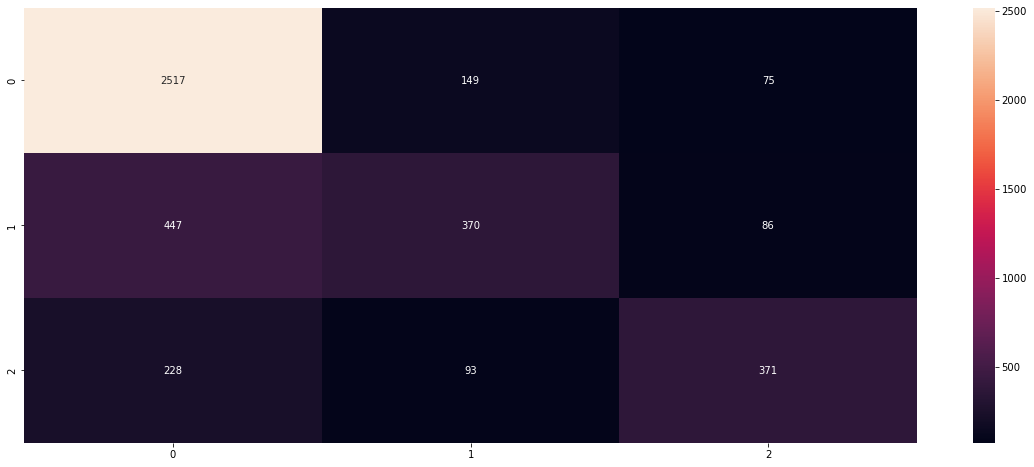

In [33]:
fig, ax = plt.subplots(figsize = (20,8))
sns.heatmap(cm, annot = True, fmt = "d",)

In [34]:
y_proba = model.predict_proba(X_test)
y_proba

array([[2.48717487e-01, 6.38104252e-01, 1.13178261e-01],
       [9.62848570e-01, 3.39634887e-02, 3.18794096e-03],
       [5.44791039e-01, 4.26277700e-01, 2.89312608e-02],
       ...,
       [9.96746626e-05, 9.99320968e-01, 5.79356969e-04],
       [9.78765245e-01, 7.25080231e-03, 1.39839525e-02],
       [8.90951146e-01, 7.67286956e-02, 3.23201583e-02]])

import joblib
joblib.dump(model,"model_twitter.joblib")

In [35]:
df

,airline,tweets,airline_sentiment,sentiment_encoded
0,Virgin America,virginamerica what dhepburn said,neutral,0
1,Virgin America,virginamerica plus youve added commercials to ...,positive,1
2,Virgin America,virginamerica i did not today must mean i need...,neutral,0
3,Virgin America,virginamerica it is really aggressive to blast...,negative,-1
4,Virgin America,virginamerica and it is a really big bad thing...,negative,-1
...,...,...,...,...
14635,American,americanair thank you we got on a different fl...,positive,1
14636,American,americanair leaving over 20 minutes late fligh...,negative,-1
14637,American,americanair please bring american airlines to ...,neutral,0
14638,American,americanair you have my money you change my fl...,negative,-1


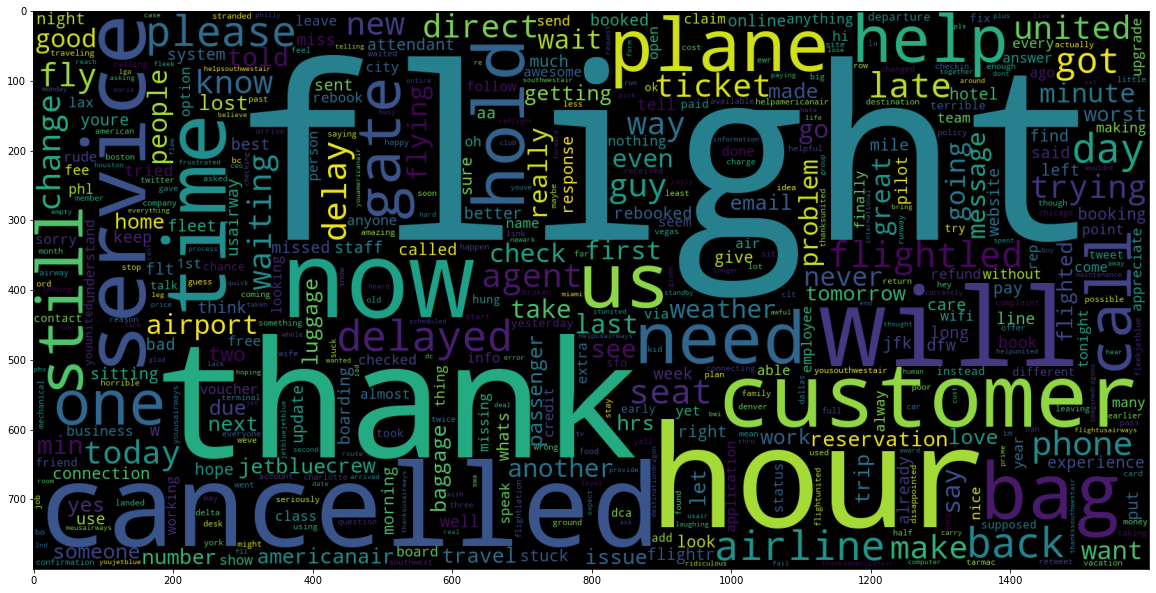

In [36]:
text = "".join(df['tweets'])
fig, ax = plt.subplots(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800,collocations=False).generate(text)
ax.imshow(wc)

In [37]:
super = df.loc[:,["tweets","airline_sentiment"]]
super[super.airline_sentiment == "negative"].tweets

3        virginamerica it is really aggressive to blast...
4        virginamerica and it is a really big bad thing...
5        virginamerica seriously would pay 30 a flight ...
15              virginamerica sfopdx schedule is still mia
17       virginamerica i flew from new york city to sfo...
                               ...                        
14631    americanair thank you for nothing on getting u...
14633    americanair my flight was cancelled flightled ...
14634             americanair right on cue with the delays
14636    americanair leaving over 20 minutes late fligh...
14638    americanair you have my money you change my fl...
Name: tweets, Length: 9087, dtype: object

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

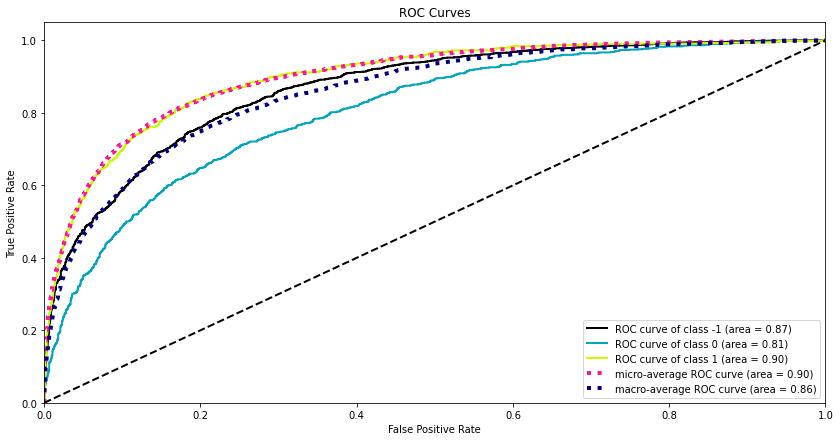

In [38]:
import scikitplot as skplt
fig, ax = plt.subplots(figsize=(14,7))
skplt.metrics.plot_roc(y_test, y_proba,ax= ax)

In [39]:
text = df['tweets'][:4]
text

0                     virginamerica what dhepburn said
1    virginamerica plus youve added commercials to ...
2    virginamerica i did not today must mean i need...
3    virginamerica it is really aggressive to blast...
Name: tweets, dtype: object